<a href="https://colab.research.google.com/github/oswap1/cc/blob/main/Proyecto_VaR_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cálculo del Valor en Riesgo (VaR) mediante Método Histórico y Simulación Monte Carlo**

Materia: Cómputo Científico

/tmp/ipython-input-9-1010767561.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if violaciones[i - 1] == 0 and violaciones[i] == 0:
/tmp/ipython-input-9-1010767561.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif violaciones[i - 1] == 0 and violaciones[i] == 1:
/tmp/ipython-input-9-1010767561.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif violaciones[i - 1] == 1 and violaciones[i] == 0:



=== Validación del VaR (Nivel 99%) ===
Histórico - Kupiec:            LR = 0.4487, p-value = 0.5030
Histórico - Christoffersen:   LR = 0.0684, p-value = 0.7937
Monte Carlo - Kupiec:         LR = -0.0000, p-value = 1.0000
Monte Carlo - Christoffersen: LR = 0.0000, p-value = 0.9999
Archivo 'resultados_VaR.xlsx' exportado correctamente.


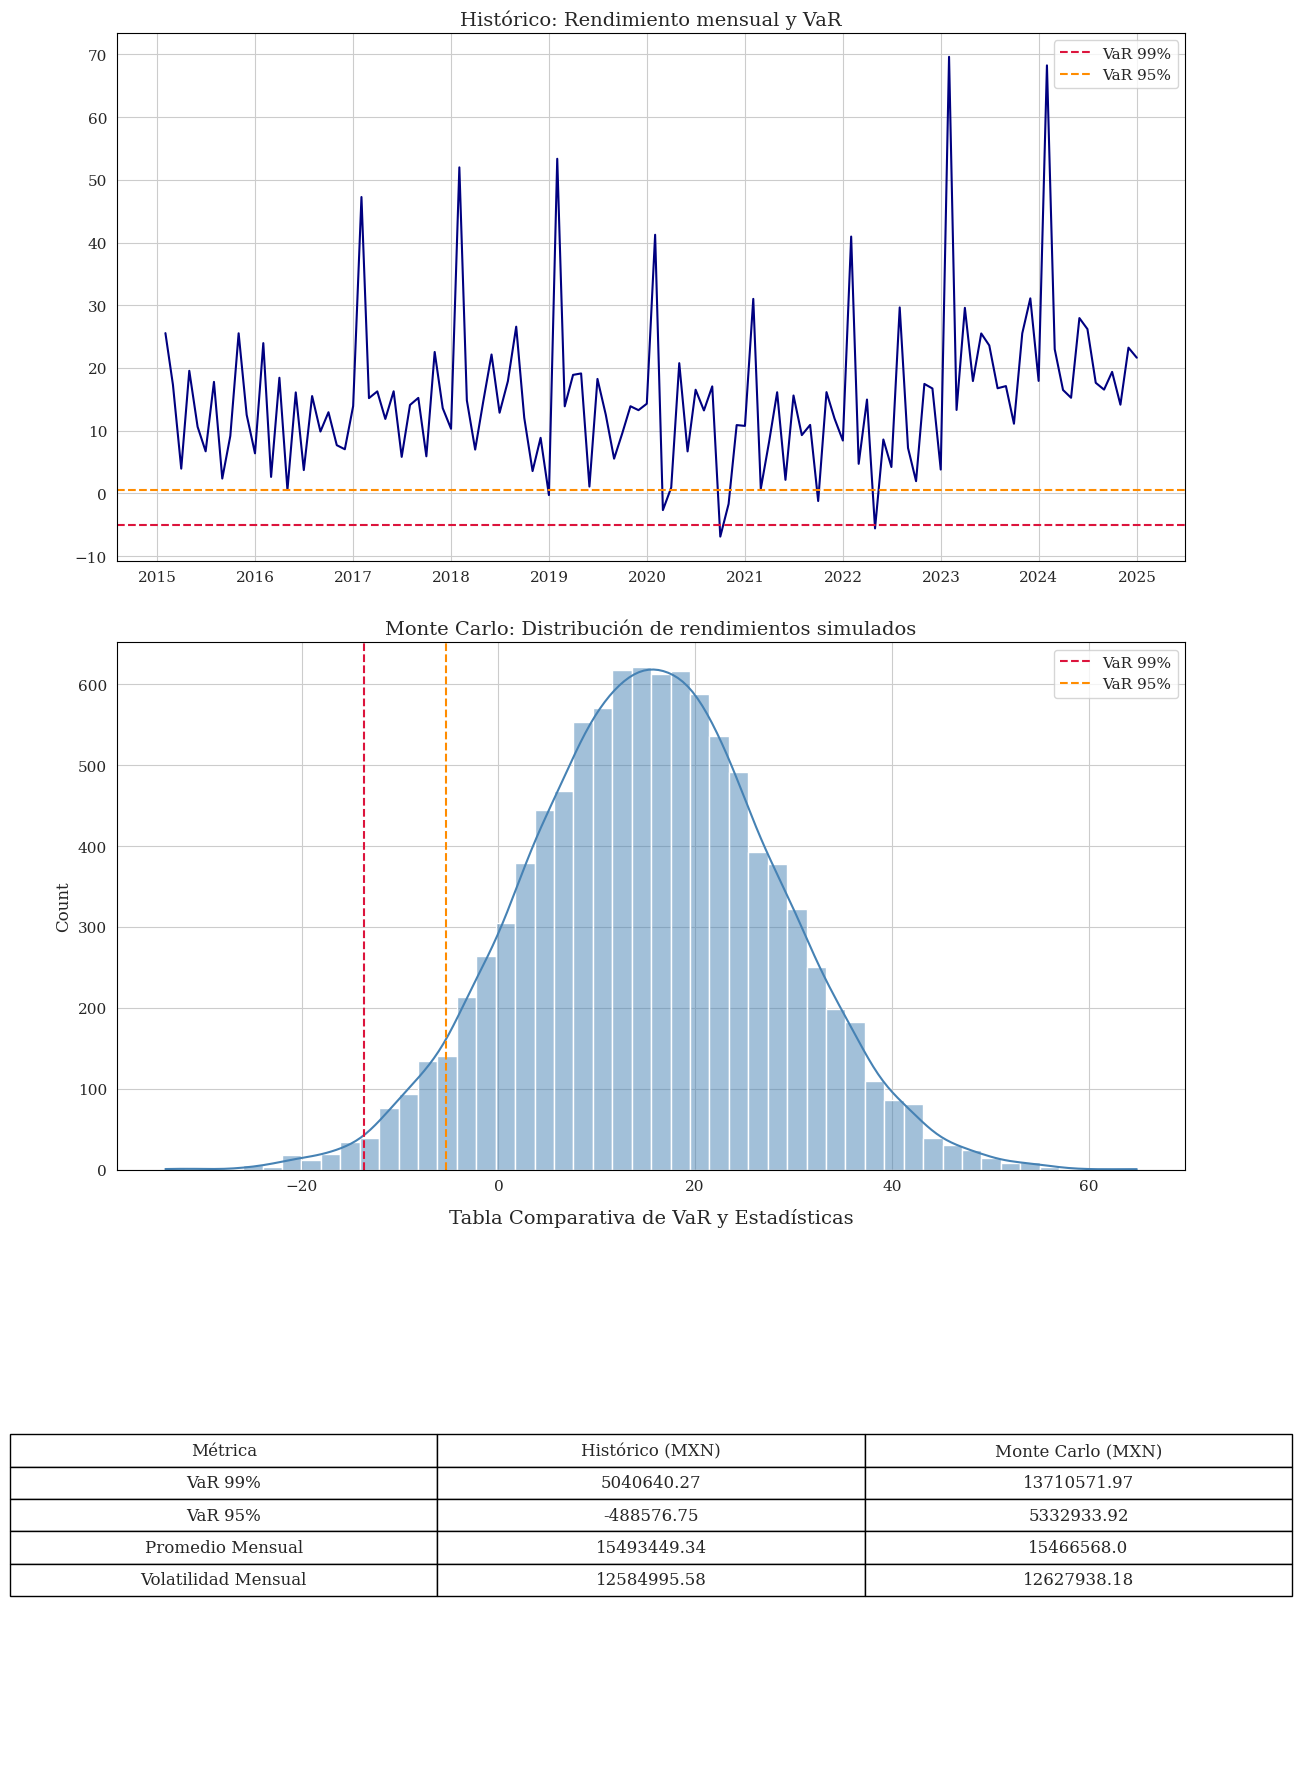

=== Resultados de VaR ===
VaR Histórico 99%:     5,040,640.27 MXN
VaR Histórico 95%:     -488,576.75 MXN
VaR Monte Carlo 99%:   13,710,571.97 MXN
VaR Monte Carlo 95%:   5,332,933.92 MXN

=== Estadísticas del Portafolio ===
Rendimiento Promedio Mensual: 15,493,449.3413
Volatilidad Mensual:           12,584,995.5831


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2

# 1. Cargar archivos
acciones_path = "/content/precios y rendimientos de acciones.xlsx"
bonos_mx_path = "/content/Bonos_MX.csv"
bonos_eu_path = "/content/Bonos_EU.csv"

rendimientos_acciones = pd.read_excel(
    acciones_path, sheet_name='Rendimientos Logarítmicos', index_col=0, parse_dates=True)
bonos_mx = pd.read_csv(bonos_mx_path)
bonos_eu = pd.read_csv(bonos_eu_path)

# 2. Limpieza y transformación bonos MX
bonos_mx = bonos_mx.replace('N/E', np.nan).dropna()
bonos_mx['Fecha'] = pd.to_datetime(bonos_mx['Fecha'], dayfirst=True)
bonos_mx.set_index('Fecha', inplace=True)
bonos_mx = bonos_mx.astype(float)
bonos_mx['r_CETES'] = np.log(1 + bonos_mx['CETES'] / 100)
bonos_mx['r_MEX10Y'] = np.log(1 + bonos_mx['MEX10Y'] / 100)
bonos_mx_m = bonos_mx[['r_CETES', 'r_MEX10Y']].resample('ME').sum()

# 3. Limpieza y transformación bonos EU
bonos_eu['Fecha'] = pd.to_datetime(bonos_eu['Fecha'], dayfirst=True)
bonos_eu.set_index('Fecha', inplace=True)
bonos_eu = bonos_eu.astype(float)
bonos_eu['r_UST10Y'] = np.log(1 + bonos_eu['UST10Y'] / 100)
ust10y_m = bonos_eu['r_UST10Y'].resample('ME').sum()

# 4. Rendimientos acciones mensuales
rend_acc_m = rendimientos_acciones.resample('ME').sum()
rend_acc_m.index.name = 'Fecha'

# 5. Unión de series para activos seleccionados
activos = ['AAPL', 'MSFT', 'AMZN']
rendimientos = pd.concat(
    [rend_acc_m[activos], bonos_mx_m, ust10y_m.rename('UST10Y')],
    axis=1
).dropna()

# 6. Pesos del portafolio
montos = {
    'AAPL': 40e6, 'MSFT': 40e6, 'AMZN': 30e6,
    'MEX10Y': 30e6, 'CETES': 20e6, 'UST10Y': 20e6
}
total = sum(montos.values())
pesos = np.array([montos[a] / total for a in activos + ['CETES', 'MEX10Y', 'UST10Y']])

# 7. Cálculo VaR Histórico
rend_port = rendimientos.dot(pesos)
hist_var_99 = -np.percentile(rend_port, 1) * total
hist_var_95 = -np.percentile(rend_port, 5) * total
hist_mean = rend_port.mean() * total
hist_std = rend_port.std() * total

# 8. Cálculo VaR Monte Carlo
np.random.seed(42)
mean = rend_port.mean()
std = rend_port.std()
simulaciones = np.random.normal(loc=mean, scale=std, size=10000)
mc_var_99 = -np.percentile(simulaciones, 1) * total
mc_var_95 = -np.percentile(simulaciones, 5) * total
mc_mean = simulaciones.mean() * total
mc_std = simulaciones.std() * total

# 9. Tabla comparativa VaR
tabla_comparativa = pd.DataFrame({
    'Métrica': ['VaR 99%', 'VaR 95%', 'Promedio Mensual', 'Volatilidad Mensual'],
    'Histórico (MXN)': [hist_var_99, hist_var_95, hist_mean, hist_std],
    'Monte Carlo (MXN)': [mc_var_99, mc_var_95, mc_mean, mc_std]
})

# 10. Definición funciones de validación VaR
def prueba_kupiec(rendimientos, var, alpha=0.01):
    violaciones = (rendimientos < -var).sum()
    n = len(rendimientos)
    p_hat = violaciones / n
    p = alpha
    if p_hat in [0, 1]:
        return np.nan, np.nan
    lr_uc = -2 * (
        np.log((1 - p)**(n - violaciones) * p**violaciones) -
        np.log((1 - p_hat)**(n - violaciones) * p_hat**violaciones)
    )
    p_value = 1 - chi2.cdf(lr_uc, df=1)
    return lr_uc, p_value

def prueba_christoffersen(rendimientos, var):
    violaciones = (rendimientos < -var).astype(int)
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(violaciones)):
        if violaciones[i - 1] == 0 and violaciones[i] == 0:
            n00 += 1
        elif violaciones[i - 1] == 0 and violaciones[i] == 1:
            n01 += 1
        elif violaciones[i - 1] == 1 and violaciones[i] == 0:
            n10 += 1
        elif violaciones[i - 1] == 1 and violaciones[i] == 1:
            n11 += 1
    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0.0001
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0.0001
    pi = (n01 + n11) / (n00 + n01 + n10 + n11) if (n00 + n01 + n10 + n11) > 0 else 0.0001
    lr_ind = -2 * (
        np.log((1 - pi)**(n00 + n10) * pi**(n01 + n11)) -
        np.log((1 - pi01)**n00 * pi01**n01 * (1 - pi11)**n10 * pi11**n11)
    )
    p_value = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, p_value

# 11. Validación VaR para histórico y Monte Carlo
kupiec_h, p_kupiec_h = prueba_kupiec(rend_port, hist_var_99 / total)
christ_h, p_christ_h = prueba_christoffersen(rend_port, hist_var_99 / total)
kupiec_mc, p_kupiec_mc = prueba_kupiec(simulaciones, mc_var_99 / total)
christ_mc, p_christ_mc = prueba_christoffersen(simulaciones, mc_var_99 / total)

print("\n=== Validación del VaR (Nivel 99%) ===")
print(f"Histórico - Kupiec:            LR = {kupiec_h:.4f}, p-value = {p_kupiec_h:.4f}")
print(f"Histórico - Christoffersen:   LR = {christ_h:.4f}, p-value = {p_christ_h:.4f}")
print(f"Monte Carlo - Kupiec:         LR = {kupiec_mc:.4f}, p-value = {p_kupiec_mc:.4f}")
print(f"Monte Carlo - Christoffersen: LR = {christ_mc:.4f}, p-value = {p_christ_mc:.4f}")

# 12. Guardar resultados en Excel
with pd.ExcelWriter("resultados_VaR.xlsx", engine='xlsxwriter') as writer:
    tabla_comparativa.to_excel(writer, sheet_name="Resumen VaR", index=False)
    validaciones_df = pd.DataFrame({
        'Método': [
            'Histórico - Kupiec', 'Histórico - Christoffersen',
            'Monte Carlo - Kupiec', 'Monte Carlo - Christoffersen'
        ],
        'LR': [kupiec_h, christ_h, kupiec_mc, christ_mc],
        'p-value': [p_kupiec_h, p_christ_h, p_kupiec_mc, p_christ_mc]
    })
    validaciones_df.to_excel(writer, sheet_name="Validaciones", index=False)

print("Archivo 'resultados_VaR.xlsx' exportado correctamente.")

# 13. Dashboard profesional
sns.set_style("whitegrid")
sns.set_palette("muted")
plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "font.family": "serif"
})

fig, axs = plt.subplots(3, 1, figsize=(13, 18), facecolor='white')

# Rendimientos portafolio y VaR histórico
axs[0].plot(rend_port.index, rend_port * total / 1e6, color='navy', linewidth=1.5)
axs[0].axhline(-hist_var_99 / 1e6, color='crimson', linestyle='--', label='VaR 99%')
axs[0].axhline(-hist_var_95 / 1e6, color='darkorange', linestyle='--', label='VaR 95%')
axs[0].set_title('Histórico: Rendimiento mensual y VaR')
axs[0].legend()
axs[0].grid(True)

# Histograma simulaciones Monte Carlo
sns.histplot(simulaciones * total / 1e6, ax=axs[1], kde=True, color='steelblue', bins=50)
axs[1].axvline(-mc_var_99 / 1e6, color='crimson', linestyle='--', label='VaR 99%')
axs[1].axvline(-mc_var_95 / 1e6, color='darkorange', linestyle='--', label='VaR 95%')
axs[1].set_title('Monte Carlo: Distribución de rendimientos simulados')
axs[1].legend()
axs[1].grid(True)

# Tabla resumen en gráfico
tabla_redonda = tabla_comparativa.round(2).astype(str)
axs[2].axis('off')
tabla_render = axs[2].table(
    cellText=tabla_redonda.values,
    colLabels=tabla_redonda.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
tabla_render.auto_set_font_size(False)
tabla_render.set_fontsize(12)
tabla_render.scale(1.2, 1.5)
axs[2].set_title("Tabla Comparativa de VaR y Estadísticas", pad=20)

plt.tight_layout()
plt.savefig("dashboard_var_profesional.png", dpi=300, facecolor='white')
plt.show()

print("=== Resultados de VaR ===")
print(f"VaR Histórico 99%:     {hist_var_99:,.2f} MXN")
print(f"VaR Histórico 95%:     {hist_var_95:,.2f} MXN")
print(f"VaR Monte Carlo 99%:   {mc_var_99:,.2f} MXN")
print(f"VaR Monte Carlo 95%:   {mc_var_95:,.2f} MXN\n")
print("=== Estadísticas del Portafolio ===")
print(f"Rendimiento Promedio Mensual: {hist_mean:,.4f}")
print(f"Volatilidad Mensual:           {hist_std:,.4f}")
